In [1]:
import numpy as np
import pandas as pd
import xgboost
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
%matplotlib inline

/Users/venkatesh/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def preprocess_data(df):
    df['Agency_no'] = df.Agency.apply(lambda x:int(x.split('_')[1]))
    df['SKU_no'] = df.SKU.apply(lambda x:int(x.split('_')[1]))
    df['Year'] = df.YearMonth.apply(lambda x:int(x/100))
    df['Month'] = df.YearMonth.apply(lambda x:int(x%100))
    df['Datetime'] = df.YearMonth.apply(lambda x: datetime(int(x/100),int(x%100),1))
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    return df

In [7]:
train_data = pd.read_csv('integrated_train.csv')
train_data = preprocess_data(train_data)
train_data = train_data.sort_values(['YearMonth','SKU','Agency'])
test_data = pd.read_csv('integrated_test.csv')
test_data = preprocess_data(test_data)
test_data = test_data.sort_values(['YearMonth','SKU','Agency'])
agency_ids = train_data.Agency_no.unique()
sku_ids = train_data.SKU_no.unique()

In [10]:
trainX = train_data.iloc[:16464,:]
trainX = trainX.reset_index(drop=True)
valX = train_data.iloc[16464:,:]
valX = valX.reset_index(drop=True)
trainy = trainX.Volume
trainy = trainy.reset_index(drop=True)
valy = valX.Volume
valy = valy.reset_index(drop=True)
trainX = trainX.drop('Volume',axis=1)
valX = valX.drop('Volume',axis=1)

In [11]:
class ARWrapper():
    def __init__(self,silent=False):
        self.model = None
        self.model_fit = None
        self.silent = silent
    def fit(self,train):#,datetimes):
        self.train_len = len(train)
        self.model = AR(train)#,dates=datetimes)
        self.model_fit = self.model.fit(ic='bic',maxiter=100)
        if(self.silent==False):
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)        
    def predict(self,test_len):
        pred = self.model_fit.predict(start=self.train_len,end=self.train_len+test_len-1,dynamic=False)
        return pred

In [12]:
def predict_volume_using_ar(trainX,trainy,valX):
    return_preds = pd.Series(np.zeros(len(valX)))
    for agency_id in agency_ids:
        for sku_id in sku_ids:
            train_indexes = trainX[(trainX.Agency_no==agency_id) & (trainX.SKU_no==sku_id) ].index
            val_indexes = valX[(valX.Agency_no==agency_id) & (valX.SKU_no==sku_id) ].index
            vol_sequence = trainy[train_indexes]
            date_sequence = trainX.loc[train_indexes].Datetime
            #print('Hist Vol',list(vol_sequence))
            #print(agency_id,sku_id,vol_sequence.size)
            #print(vol_sequence.size,val_indexes.size)
            try:
                if vol_sequence.size > val_indexes.size and vol_sequence.size > 6:
                    ar = ARWrapper(silent=True)
                    ar.fit(vol_sequence.values)#,date_sequence)
                    pred = ar.predict(val_indexes.size)
                    #print('Predicted Vol',pred)
                    return_preds[val_indexes]=pred
            except:
                pass
    return_preds[return_preds<0]=0
    return return_preds

In [ ]:
def generate_submission_ar():
    trainX = train_data.copy()
    trainX = trainX.reset_index(drop=True)
    trainy = trainX.Volume
    trainy = trainy.reset_index(drop=True)
    trainX = trainX.drop('Volume',axis=1)

    valX = test_data.copy()
    valX = valX.reset_index(drop=True)
    preds = predict_volume_using_ar(trainX,trainy,valX)
    valX['Volume'] = preds
    valX.loc[:,['Agency','SKU','Volume']].to_csv('volume_forecast.csv',index=False)
    print('Done generating volume_forecast.csv')

generate_submission_ar()
    

In [15]:
def accuracy(actual,pred):
    sum_diff = np.sum(np.abs(actual-pred))
    sum_actual = np.sum(actual)
    print(sum_diff,sum_actual)
    return 1- (sum_diff/sum_actual)
accuracy(np.array([1,1,1,1]),np.array([1,1,1,0]))

1 4


0.75

In [16]:
def show_autoregressive_plots(demand):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    demand.plot()
    plt.subplot(122)
    pd.plotting.lag_plot(demand)
    plt.show()
    pd.plotting.autocorrelation_plot(demand)
    plt.show()

In [17]:
def run_and_predict_with_ar_model():
    predictions = predict_volume_using_ar(trainX,trainy,valX)
    print(accuracy(valy,predictions))

/Users/venkatesh/anaconda/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:770: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs


In [25]:
def run_xgboost(trainX,trainy,valX,valy):
    %matplotlib notebook
    dtrain = xgboost.DMatrix(data=trainX,label=trainy)
    dval = xgboost.DMatrix(data=valX,label=valy)
    fig = plt.figure()
    axis = fig.add_subplot(111)
    param={ 'silent':1,
        'eta':0.08,'max_depth':6,'subsample':0.8,
        'objective':'reg:linear'}
    evals = [(dtrain,'train'),(dval,'val')]
    evals_result={}
    train_error=[]
    val_error=[]
    num_rounds = 150
    bst = None
    for i in range(num_rounds):
        bst = xgboost.train(param,dtrain,1,evals=evals,evals_result=evals_result,
                       verbose_eval=False)
        ptrain = bst.predict(dtrain,output_margin=True)
        pval = bst.predict(dval,output_margin=True)
        dtrain.set_base_margin(ptrain)
        dval.set_base_margin(pval)
        train_error.append(evals_result['train']['rmse'][0])
        val_error.append(evals_result['val']['rmse'][0])
        axis.clear()
        axis.set_xlim(right=num_rounds)
        axis.plot(np.arange(len(train_error)),train_error)
        axis.plot(np.arange(len(val_error)),val_error)
        fig.canvas.draw()
    print(evals_result)
    print(bst.get_score(importance_type='weight'))
    print(bst.get_score(importance_type='gain'))

In [142]:
#features=['Agency_no', 'SKU_no', 'Year', 'Month','Temp']
regressor = xgboost.XGBRegressor(max_depth=5,n_estimators=100)
regressor.fit(pd.DataFrame(trainy-(np.random.randn(len(trainy)))),trainy)
pred = regressor.predict(pd.DataFrame(valy-(np.random.randn(len(valy)))))
print(accuracy(valy,pred))

8247.80481522655 3286871.317649995
0.9974906821660656


<IPython.core.display.Javascript object>


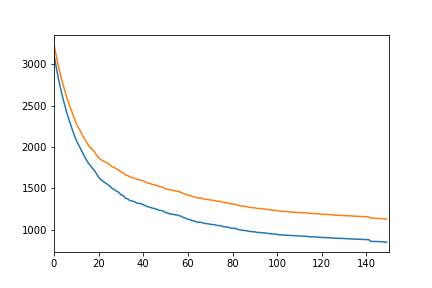

{'train': {'rmse': [853.006531]}, 'val': {'rmse': [1132.397949]}}
{'Agency_no': 16, 'SKU_no': 28}
{'Agency_no': 940807.599375, 'SKU_no': 1909342.575564643}


In [130]:
run_and_predict_with_xg_boost(trainX[features],trainy,valX[features],valy)

In [101]:
def generate_submission_xgboost():
    trainX = train_data.copy()
    trainX = trainX.reset_index(drop=True)
    trainy = trainX.Volume
    trainy = trainy.reset_index(drop=True)
    trainX = trainX.drop('Volume',axis=1)

    valX = test_data.copy()
    valX = valX.reset_index(drop=True)
    features=['SKU_no','Agency_no','Year']
    regressor = xgboost.XGBRegressor(max_depth=8,n_estimators=1000)
    regressor.fit(trainX[features],trainy)
    preds = regressor.predict(valX[features])   
    preds[preds<0]=0
    valX['Volume'] = preds
    valX.loc[:,['Agency','SKU','Volume']].to_csv('volume_forecast.csv',index=False)
    print('Done generating volume_forecast.csv')

#generate_submission_xgboost()
    

Done generating volume_forecast.csv


In [37]:
valX.tail()

,Agency,SKU,YearMonth,Price,Sales,Promo,Temp,SodaVol,Easter,GoodFriday,...,BeerCapital,MusicFest,IndVol,Popu,Income,Agency_no,SKU_no,Year,Month,Datetime
1980,Agency_09,SKU_27,201712,3349.859155,3349.859155,0.000000,31.129991,919709619,0,0,...,0,0,618073219,1646094,213511,9,27,2017,12,2017-12-01
1981,Agency_03,SKU_32,201712,2418.802817,2176.901409,241.901408,21.709841,919709619,0,0,...,0,0,618073219,1538040,217280,3,32,2017,12,2017-12-01
1982,Agency_10,SKU_32,201712,1971.412842,1755.903770,215.509072,26.631218,919709619,0,0,...,0,0,618073219,1716027,117463,10,32,2017,12,2017-12-01
1983,Agency_02,SKU_34,201712,1533.325424,1525.152673,8.172751,24.044558,919709619,0,0,...,0,0,618073219,3137874,240809,2,34,2017,12,2017-12-01
1984,Agency_49,SKU_34,201712,1507.114831,1501.108475,6.006356,24.503584,919709619,0,0,...,0,0,618073219,1880416,154532,49,34,2017,12,2017-12-01


In [102]:
trainX.columns

Index(['Agency', 'SKU', 'YearMonth', 'Price', 'Sales', 'Promo', 'Temp',
       'SodaVol', 'Easter', 'GoodFriday', 'NewYear', 'Christmas', 'LaborDay',
       'IndDay', 'RevDay', 'RegGames ', 'BeerCapital', 'MusicFest', 'IndVol',
       'Popu', 'Income', 'Agency_no', 'SKU_no', 'Year', 'Month', 'Datetime'],
      dtype='object')

In [114]:
pd.DataFrame(trainy)

,Volume
0,80.676000
1,6512.940000
2,3546.720000
3,21.816000
4,8780.508000
5,6841.044000
6,128.304000
7,4272.048000
8,2767.500000
9,316.440000


In [135]:
trainy-100*np.random.randn(len(trainy))

0          56.995738
1        6496.095471
2        3602.720717
3        -103.895024
4        8820.098054
5        6741.116489
6         265.858251
7        4202.627599
8        2664.718113
9         307.548560
10       9150.227177
11       6130.266974
12        906.757482
13       9253.916407
14         92.860031
15        -16.238315
16       3674.035077
17       -119.571404
18        -34.714696
19        -97.737004
20         74.530891
21         30.224443
22       1214.459545
23         95.238072
24        -30.455198
25       1130.285586
26        278.970080
27       1611.613175
28       7576.343956
29       2406.996297
            ...     
16434     -34.246315
16435     118.759230
16436     122.663457
16437      99.183642
16438    -119.914087
16439      46.965345
16440     211.615523
16441      99.245629
16442     -95.299013
16443     -49.424784
16444     -16.431963
16445      82.588749
16446     -51.950148
16447     -37.452088
16448      14.444666
16449     168.563611
16450     190

In [150]:
for agency_id in agency_ids:
    # Find the best sku
    for sku_id in sku_ids:
        profit_per_hl = (trainX[(trainX.Agency_no==agency_id)&
                     (trainX.SKU_no==sku_id)&(trainX.Year==2017)&(trainX.Month==6)].Sales.values[0])
        volume = (trainX[(trainX.Agency_no==agency_id)&
                     (trainX.SKU_no==sku_id)&(trainX.Year==2017)&(trainX.Month==6)].Volume.values[0])
        print(volume)
        break
    break

AttributeError: 'DataFrame' object has no attribute 'Volume'